##連結 Google Deive，以讀取目錄中的圖片資料

In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# 指定Google Drive云端硬盘的根目录，名为drive
!mkdir -p drive
!google-drive-ocamlfuse drive
# 指定当前的工作目录
import os

# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("drive/") 

# 查看文件目录，是否包含所需的文件
!ls

E: Package 'python-software-properties' has no installation candidate

Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=h

In [0]:
import keras
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout,Input
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd 
import numpy as np

Using TensorFlow backend.


## 設定參數

In [0]:
 #資料路徑
DATASET_PATH  = 'image_data2'

# 影像大小
IMAGE_SIZE = (224,224)

# 影像類別數
NUM_CLASSES = 5

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 16

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 100



## 建立模型

In [0]:
# 以訓練好的基礎來建立模型，
# 捨棄頂層的 fully connected layers
keras.backend.clear_session()
net = VGG16 (include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step


In [0]:
#增加層數
D_rate = 0.3

x = Flatten()(x)
x = Dropout(D_rate)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='output')(x)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer,name='vgg16_pretrain')

if FREEZE_LAYERS == -1 :
    for layer in net_final.layers:
        layer.trainable = False
else:
    for layer in net_final.layers[:FREEZE_LAYERS]:
        layer.trainable = False

    for layer in net_final.layers[FREEZE_LAYERS:]:
        layer.trainable = True


In [0]:
# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer = Adam(lr=1e-5),loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## 設定 callbacks 函式

In [0]:
earlystop = EarlyStopping(monitor="val_loss", patience=5,verbose=1 )
reduce_lr = ReduceLROnPlateau(factor=0.2,min_lr=1e-12, monitor='val_loss', patience=5, verbose=1)

callbacks = [earlystop,reduce_lr]

## 訓練模型

In [0]:
# 透過 data augmentation 產生訓練與驗證用的影像資料


train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.3,
                                   zoom_range=0.2,
                                   channel_shift_range=20,
                                   horizontal_flip=True,
                                   fill_mode= "nearest",
                                   rescale= 1./255,
                                   vertical_flip = True,
                                   zca_whitening = False,
                                   featurewise_center=True,  
                                   samplewise_center=True, 
                                   featurewise_std_normalization=True, 
                                   samplewise_std_normalization=True)

train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation = "bicubic",
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode= "nearest",
                                   rescale= 1./255,
                                   vertical_flip = True,
                                   zca_whitening = False,
                                   featurewise_center=True,  
                                   samplewise_center=True, 
                                   featurewise_std_normalization=True, 
                                   samplewise_std_normalization=True)

valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation ="bicubic",
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)
# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
    
# 訓練模型
history = net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS,callbacks=callbacks)



Instructions for updating:
Use tf.cast instead.
Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


176/176 [==============================] - 1777s 10s/step - loss: 1.2937 - acc: 0.4670 - val_loss: 0.8370 - val_acc: 0.6900
Epoch 2/100
176/176 [==============================] - 66s 377ms/step - loss: 0.7308 - acc: 0.7309 - val_loss: 0.4979 - val_acc: 0.8205
Epoch 3/100
176/176 [==============================] - 64s 362ms/step - loss: 0.5723 - acc: 0.7819 - val_loss: 0.4569 - val_acc: 0.8308
Epoch 4/100
176/176 [==============================] - 64s 366ms/step - loss: 0.4747 - acc: 0.8277 - val_loss: 0.4310 - val_acc: 0.8231
Epoch 5/100
176/176 [==============================] - 64s 362ms/step - loss: 0.4051 - acc: 0.8544 - val_loss: 0.3104 - val_acc: 0.8615
Epoch 6/100
176/176 [==============================] - 64s 364ms/step - loss: 0.3825 - acc: 0.8608 - val_loss: 0.3446 - val_acc: 0.8641
Epoch 7/100
176/176 [==============================] - 64s 364ms/step - loss: 0.3535 - acc: 0.8704 - val_loss: 0.3839 - val_acc: 0.8744
Epoch 8/100
176/176 [==============================] - 64s 3

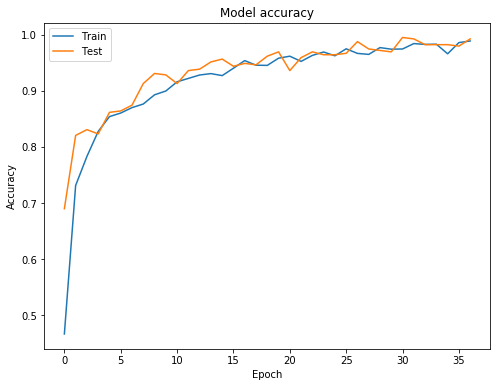

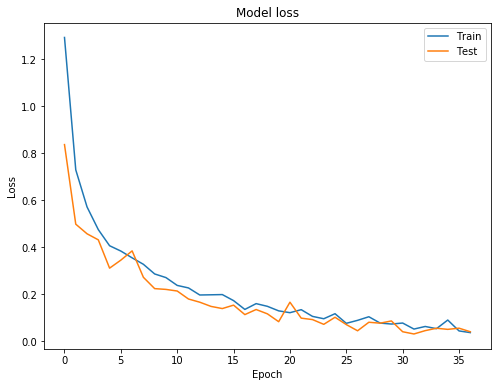

平均驗證穩準確率為 0.934250
平均驗證穩損失率為 0.178541


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()         

print(f"平均訓練準確率為 {np.mean(history.history['acc']):4f}")
print(f"平均驗證準確率為 {np.mean(history.history['val_acc']):4f}")

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

print(f"平均訓練損失率為 {np.mean(history.history['loss']):4f}")
print(f"平均驗證損失率為 {np.mean(history.history['val_loss']):4f}")


In [0]:
# 儲存訓練好的模型
net_final.save( 'flower_identify_VGG16_01.h5')

## 預測結果

In [0]:
import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from tqdm import tqdm

In [0]:
# 載入訓練好的模型
net = load_model('flower_identify_VGG16_01.h5')

## 辨識每一張圖

In [49]:
#測試資料預處裡設定圖形產生器
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=0,
                                  zca_whitening = True,
                                  featurewise_center=True,  
                                  samplewise_center=True, 
                                  featurewise_std_normalization=True, 
                                  samplewise_std_normalization=True)

test_batches = test_datagen.flow_from_directory('image_data/test',
                                                target_size = (224,224),
                                                interpolation = "bicubic",
                                                class_mode = 'categorical',
                                                shuffle = False,
                                                batch_size = 50)

#設定儲存資料的串列及DataFrame
Pred_result = pd.DataFrame(columns=['id'])

#將圖檔名稱轉換成預測 id 並將 id 存入串列
print("\n載入要預測圖檔的名稱....\n")
for filename in tqdm(test_batches.filenames):
    Pred_result = Pred_result.append({'id':filename.split('/')[1].split('.')[0]},
                                      ignore_index = True) 
#載入要預測的圖像
print("\n載入圖檔預測中...\n")
pred = net.predict_generator(test_batches,steps=2000/50,verbose=1)
result = pd.DataFrame(pred.argsort())
Pred_result['flower_class'] = result[4]
Pred_result.head(5)   

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:339: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '
  4%|▍         | 75/2000 [00:00<00:02, 745.22it/s]

Found 2000 images belonging to 1 classes.

載入要預測圖檔的名稱....



100%|██████████| 2000/2000 [00:02<00:00, 748.86it/s]
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:718: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



載入圖檔預測中...

40/40 [==============================] - 15s 367ms/step


,id,flower_class
0,0028624c49b3e0610ff9f1d111f5d532,2
1,002c30700185b7971369258b438070d5,4
2,00852f4f666acecd0c0d140365b42efd,4
3,00c08828fce04e360c732cac01edad9e,4
4,00d366e7877b6a78b104b57d67b60e6b,4


## 輸出預測結果檔案

In [0]:
Pred_result.to_csv('Flowerclass_21.csv',index = False)